### IMBH Forecast

In [367]:
%matplotlib inline
import sys, os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from multiprocessing import Pool

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

from model import DemographicModel, ERDF_blue, ERDF_red, calc_sigma_var, lambda_obs, get_AGN_flux, get_RIAF_flux, GSMF_red, GSMF_stellar, f_occ_heavyMS

In [368]:
def set_mpl_style(fsize=15, tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0):
    
    """Function to set MPL style"""

    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [369]:
set_mpl_style()

In [370]:
Mdot = 1e-8*u.Msun/u.yr
eta = 0.2
M_BH = 1e3*u.Msun
L_bol = Mdot * eta *const.c**2
L_Edd = 1.26e38 * M_BH.to(u.Msun).value * u.erg/u.s
np.log10(L_bol.to(u.erg/u.s) / L_Edd)

<Quantity -3.0462972>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


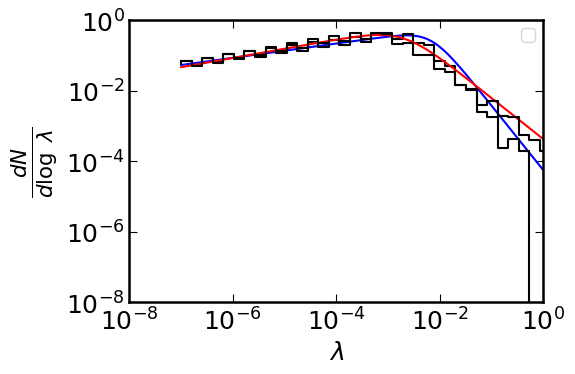

In [371]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-7, 1, 100)
dlogl = np.diff(np.log10(l))[0]

colors =['b', 'r']

for i, ERDF in enumerate([ERDF_blue, ERDF_red]):

    p = ERDF(l)*dlogl
    p = p/np.sum(p)
    s = np.random.choice(l, 100000, p=p)

    ax.loglog(l, p/dlogl, c=colors[i])

    bins = np.logspace(-7, 3, 50)
    h, bin_edges = np.histogram(s, bins=bins)
    ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s), color='k')

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.legend(fontsize=12)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-8, 1e0)
ax.set_ylim(1e-8, 1e0)

fig.tight_layout()

$\dot{M}(R) = \dot{M}{\rm o} \left( R/R{\rm o} \right)^{s}$ (or $\rho(R) \propto R^{-3/2+s}$) where $\dot{M}{\rm o}$ is the rate measured at the outer radius $R{\rm o}$ of the RIAF (Blandford & Begelman 1999).

In [372]:
#plt.loglog(np.logspace(0, 6), sed)

### Load previous model instance

In [373]:
# May need to run one at a time to save memory
keys = ['ptf']
#keys = ['lsst']
#keys = ['des-sn']

In [374]:
load = False # Load previous model?
ERDF_mode = 0 # 1 for lambda ~ log Mstar^4.5
debug = False

nbootstrap = 16
nbins = 20

# Assuming ~SDSS solid angle 14000*u.deg**2
omegas = {'ptf':14000*u.deg**2, 'lsst':18000*u.deg**2, 'des-sn':4.64*u.deg**2}
zmaxes = {'ptf':0.055, 'lsst':0.055, 'des-sn':1.5}
ndraws = {'ptf':1e11, 'lsst':5e10, 'des-sn':5e8}
etas = {'ptf':10, 'lsst':100, 'des-sn':100}

bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}

# Colors
colors = {'light':'b','heavy':'m','light_stellar':'g','a':'cyan'}
markers = {'light':'s','heavy':'o','light_stellar':'^','a':'o'}
zorders = {'light':3,'heavy':2,'light_stellar':1,'a':1}

models = {}
for key in keys:
    
    debug_str = ''
    
    # speed up?
    if debug:
        debug_str = '_debug'
        etas[key] = etas[key]*10
        nbootstrap = 2
    
    # ERDF mode
    if ERDF_mode == 1:
        workdir = f'/data3/colinjb2/{key}_A{debug_str}'
    else:
        workdir = f'/data3/colinjb2/{key}{debug_str}'
        
    print(workdir)
    
    models[key] = DemographicModel(workdir=workdir, survey=key, load=load)
    omega_sr = omegas[key].to(u.sr).value
    
    if not load:
        if ERDF_mode == 1:
            models[key].sample(nbins=nbins, nbootstrap=nbootstrap, zmax=zmaxes[key], eta=etas[key],
                               ndraw_dim=ndraws[key]/etas[key], omega=omega_sr, ERDF_mode=1,
                               seed_dict={'a':(lambda x: np.ones_like(x))})
        else:
            models[key].sample(nbins=nbins, nbootstrap=nbootstrap, zmax=zmaxes[key], eta=etas[key],
                               ndraw_dim=ndraws[key]/etas[key], omega=omega_sr, ERDF_mode=0)

/data3/colinjb2/ptf_debug
Omega: 4.26464387701392
eta: 100
Using Reines et al. 2015 host-BH mass relation for low redshifts
log M_star bins:  [ 5.01  5.41  5.81  6.21  6.61  7.01  7.41  7.81  8.21  8.61  9.01  9.41
  9.81 10.21 10.61 11.01 11.41 11.81 12.21 12.61]
log M_BH bins:  [2.01 2.41 2.81 3.21 3.61 4.01 4.41 4.81 5.21 5.61 6.01 6.41 6.81 7.21
 7.61 8.01 8.41 8.81 9.21 9.61]
log lambda bins:  [-7.93 -7.48 -7.03 -6.58 -6.13 -5.68 -5.23 -4.78 -4.33 -3.88 -3.43 -2.98
 -2.53 -2.08 -1.63 -1.18 -0.73 -0.28  0.17  0.62]


  0%|          | 0/2 [00:00<?, ?it/s]

log N galaxies:  7.4
7.39 5.37 4.38
Sampling host galaxy colors
Sampling ERDF
Sampling occupation probability
log N BHs:  5.42
log N BHs:  5.42
log N BHs:  7.4
log N galaxies:  7.91
7.91 5.23 4.33
Sampling host galaxy colors
Sampling ERDF
Sampling occupation probability
log N BHs:  5.28
log N BHs:  5.28
log N BHs:  7.91


### Host galaxy colors and dilution

In [375]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
# Load NASA Sloan Atlas (DR13)
hdul_nsa = fits.open('/data3/nsa_v0_1_2.fits') ## OLD VERSION!
data_nsa = hdul_nsa[1].data

17.52942


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


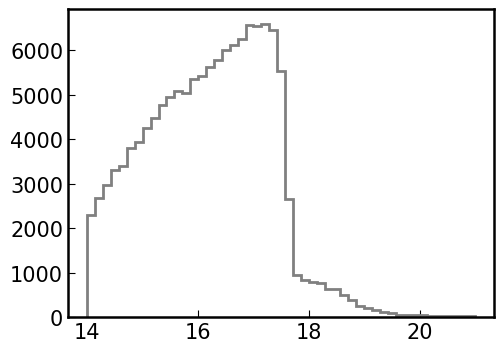

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
g = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) # g
r = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,4]) # r

R = r - 0.1837*(g-r) - 0.0971

print(17.7 - 0.1837*0.4 - 0.0971)

ax.hist(R, bins=np.linspace(14, 21), color='gray', histtype='step', lw=2);
#ax.set_yscale('log')

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10


[-0.33937797 12.42385662 -3.22471183]
0.6542997
[-0.26538072 20.74996085 -4.52352042]
0.49359372
[-0.34593204 13.4809179  -3.75957238]
0.42963484
[-0.38260452  5.94893356 -1.38837847]
0.33698055
[-0.37753156  5.17829934 -1.07462101]
0.32554898
[-0.26534081  2.63948307  0.29002935]
0.2898828


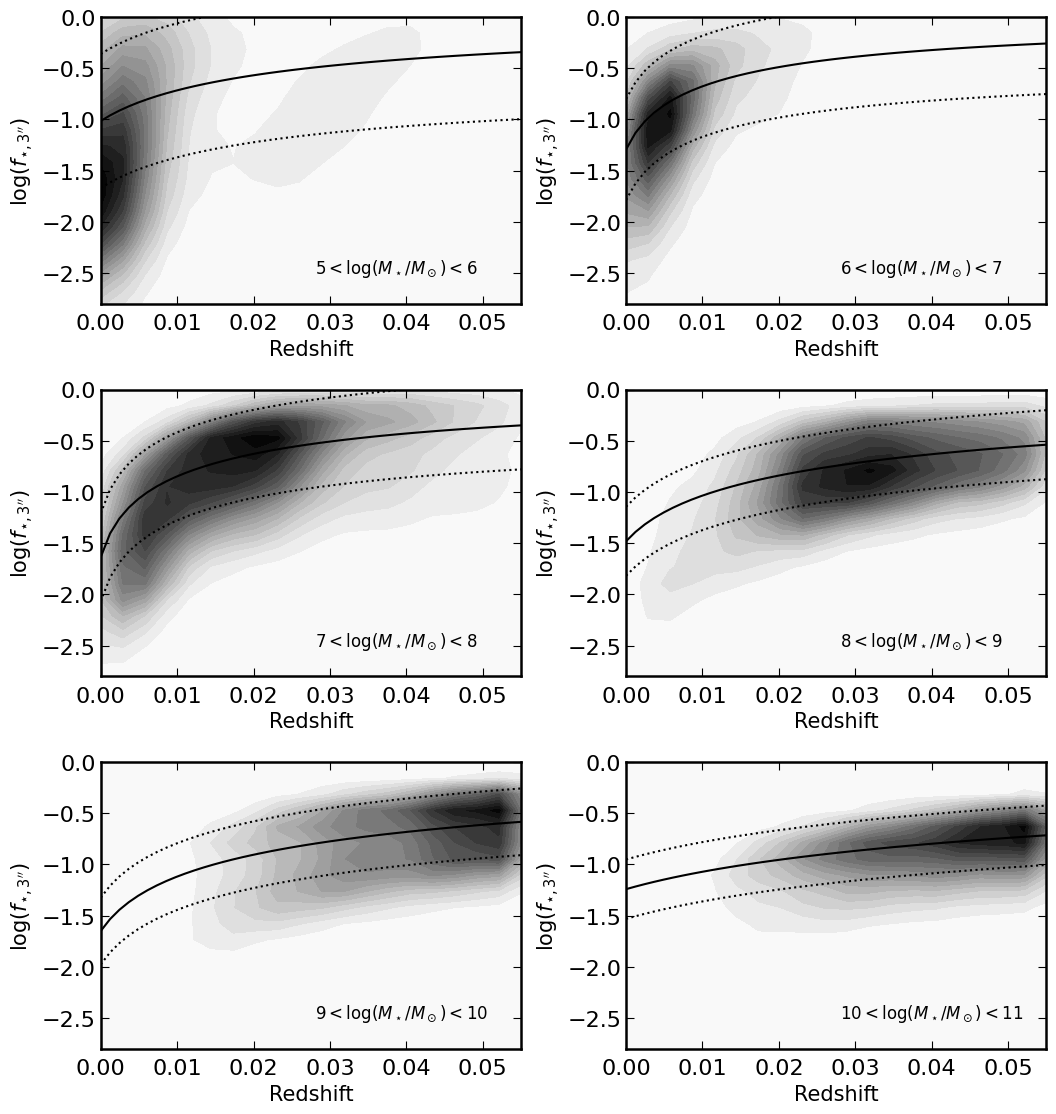

In [377]:
from scipy.optimize import curve_fit

M_star_bins = np.arange(5, 11, 1)

# FUV NUV u g r i z 
f_host = data_nsa['FIBERFLUX'][:,3]/data_nsa['PETROFLUX'][:,3]
stellar_mass = data_nsa['MASS'] * (0.7)**2

# Overall values

mask_na = np.isfinite(data_nsa['Z']) & (f_host<1) & (f_host>0)

fig, axs = plt.subplots(len(M_star_bins)//2, 2, figsize=(2*5.3, len(M_star_bins)//2*3.8))

xx, yy = np.mgrid[0:0.055:20j, -3:0:20j]
positions = np.vstack([xx.ravel(), yy.ravel()])


# Define the fitting function
def func(x, a, b, c):
    #x = np.log10(1 + x)
    x = x-a
    return 1 - 1/(x**2 + b*x + c)


# Mass bin loop
for i, M_star in enumerate(M_star_bins):
    ax = axs.flatten()[i]
    
    bin_lo = 10**M_star_bins[i]
    bin_hi = 10**(M_star_bins[i] + 1)
    
    mask_na = np.isfinite(data_nsa['Z']) & (f_host<1) & (f_host>0) & (stellar_mass > bin_lo) & (stellar_mass < bin_hi)
    values = np.vstack([data_nsa['Z'][mask_na], np.log10(f_host[mask_na])])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cfset = ax.contourf(xx, yy, f, levels=20, cmap='binary')
    

    #ax.scatter(data_nsa['Z'], np.log10(f_host), s=0.001, c='gray')
    ax.set_ylim([-2.8, 0])
    ax.set_xlim([0, 0.055])

    p, pcov = curve_fit(func, data_nsa['Z'][mask_na], f_host[mask_na])
    x = np.linspace(0, 0.06)
    ax.plot(x, np.log10(func(x, *p)), color='k')

    print(p)

    res = np.log10(f_host[mask_na]) - np.log10(func(data_nsa['Z'][mask_na], *p))

    rms = np.nanstd(res)
    print(np.nanstd(res))

    ax.plot(x, np.log10(func(x, *p)) - rms, color='k', linestyle='dotted')
    ax.plot(x, np.log10(func(x, *p)) + rms, color='k', linestyle='dotted')

    ax.set_ylabel(r'$\log(f_{\star, {\rm{3^{\prime\prime}}}})$')
    ax.set_xlabel(r'Redshift')
    
    ax.text(0.028, -2.5, fr'${M_star_bins[i]} < \log(M_\star/M_\odot) < {M_star_bins[i] + 1}$', fontsize=12)

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
fig.savefig('fhost.pdf', dpi=300)

### Plot model summary figure

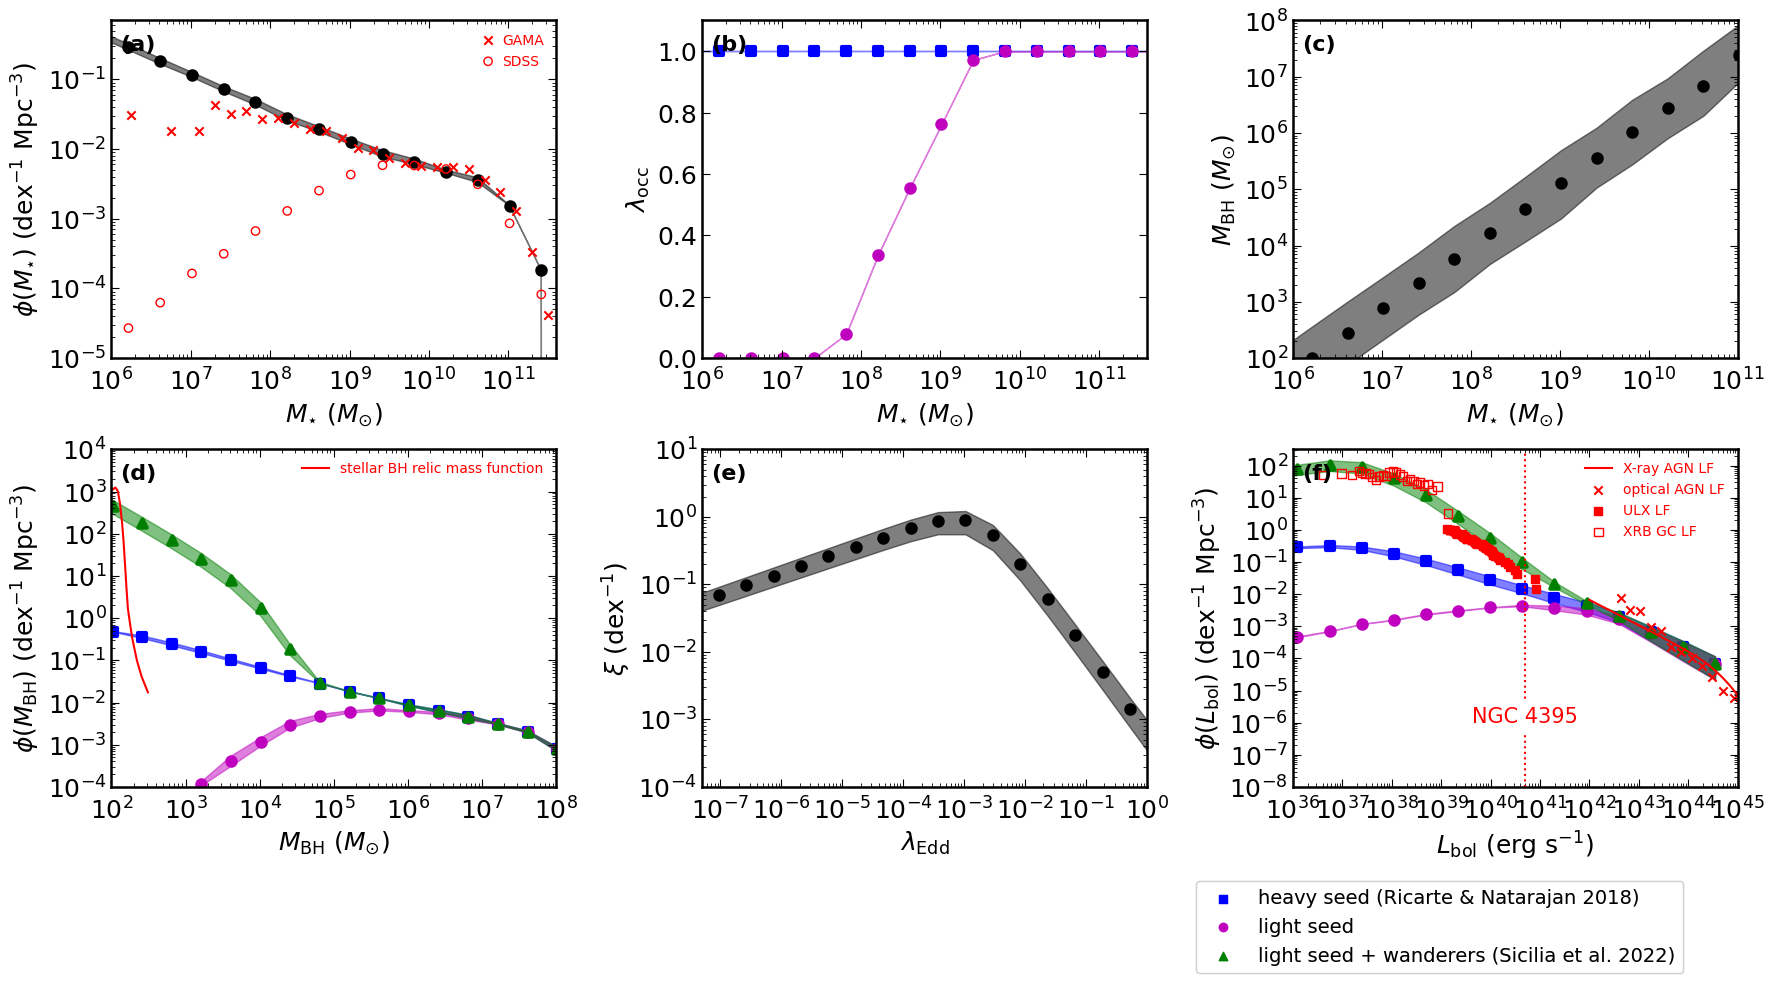

In [378]:
plot = True

# Parameters
pars = {}
for key in keys:
    pars[key] = models[key].pars

stellar_mass = data_nsa['MASS'] * (0.7)**2
M_star_ = pars[keys[0]]['M_star_'].value
M_star = pars[keys[0]]['M_star'].value
n_i, _ = np.histogram(stellar_mass, bins=M_star_)
dlogM_star = np.diff(np.log10(M_star_))


omega = (9380*u.deg**2).to(u.sr) # DR8 https://www.sdss3.org/dr8/
V = cosmo.comoving_volume(0.055)*omega/(4*np.pi)
phi_i = n_i/V/dlogM_star

def phi_X(L_X):
    # https://iopscience.iop.org/article/10.1088/0004-637X/749/1/21/pdf
    
    A = 113.1*1e-7
    L_br = 0.51*1e44
    gamma1 = 0.79
    gamma2 = 2.39
    # z=0
    return A/(np.log(10)) * ((L_X/L_br)**gamma1 + (L_X/L_br)**gamma2)**-1 #1/L_X

# Real data
# https://ui.adsabs.harvard.edu/abs/2009A%26A...507..781S/exportcitation
x = np.array([42.63,42.83,43.03,43.24,43.44,43.65,43.86,44.07,44.28,44.49,\
              44.71,44.93,45.15,45.38,45.60,45.82,46.05,46.28,46.51])
y = np.array([-2.12,-2.48,-2.52,-3.02,-3.16,-3.64,-3.80,-3.98,-4.24,-4.59,\
              -5.02,-5.24,-5.93,-6.42,-6.77,-6.98,-7.45,-7.78,-8.34])

# Plot
if plot and etas[key] >= 1:

    fig_ptf = models[keys[0]].plot(seed_colors=colors, seed_markers=markers, n_bin_min=50, moct=np.nanmedian)
    #fig_lsst = model_lsst.plot()

    axs = fig_ptf.axes
    axs[0].scatter(M_star, phi_i, marker='o', facecolors='none', edgecolors='r', label='SDSS')
    l = axs[0].legend(fontsize=10, frameon=False, handletextpad=0)
    for text in l.get_texts():
        text.set_color("red")
        
    # BHMF
    dat = np.loadtxt('BHMF_stellar.txt', delimiter=',')
    axs[3].plot(10**dat[:,0], 10**dat[:,1], color='r', label='stellar BH relic mass function')
    l = axs[3].legend(fontsize=10, frameon=False)
    for text in l.get_texts():
        text.set_color("red")
    
    # LF
    L_X = np.logspace(41, 46)
    dlogL_X = np.diff(np.log10(L_X))[0]
    axs[-1].plot(L_X/1e-1, phi_X(L_X)/dlogL_X, color='r', label='X-ray AGN LF')
    axs[-1].scatter(10**x, 10**y, c='r', marker='x', label='optical AGN LF')
    # ULX
    dat = np.loadtxt('ulx_lf.txt', delimiter=',') 
    # phi = dn / dlog L  = dN / dV / dlog L
    dV = 1/1e-1 # Mpc^-3 normalized to number density of ~10^8 Msun galaxies
    mask = dat[:,0] > 39
    axs[-1].scatter(10**dat[:,0][mask]/0.8, 10**dat[:,1][mask]/dV/7, color='r', marker='s', label='ULX LF')
    # XRB
    dat = np.loadtxt('lmxrb_lf.txt', delimiter=',')
    dV = 1/1e-1 # Mpc^-3 normalized to number density of ~10^8 Msun galaxies
    axs[-1].scatter(10**dat[:,0]/0.8, dat[:,1]/dV, color='r', marker='s', facecolors='none', label='XRB GC LF')
    
    legend1 = plt.legend(fontsize=10, frameon=False)
    for text in legend1.get_texts():
        text.set_color("red")
    
    # NGC 4395 (Moran 1999)
    axs[-1].axvline(5e40, 0, 1, color='r', linestyle='dotted')
    t = axs[-1].text(5e40, 1e-6, 'NGC 4395', color='r', ha='center')
    t.set_bbox(dict(facecolor='w', edgecolor='w'))
    
    # Add legend outside figure
    lines = []
    for i, seed in enumerate(models[keys[0]].pars['seed_keys']):
        lines.append(axs[-1].scatter(0, 0, marker=markers[seed], color=colors[seed]))
    
    labels = ['heavy seed (Ricarte & Natarajan 2018)', 'light seed', 'light seed + wanderers (Sicilia et al. 2022)']
    
    legend2 = plt.legend(lines, labels, bbox_to_anchor=(0.90, -.25), fontsize=14)
    axs[-1].add_artist(legend1)
    axs[-1].add_artist(legend2)

    fig_ptf.subplots_adjust(bottom=0.2)
    fig_ptf.savefig('model.pdf', dpi=300)

(100.0, 100000000.0)

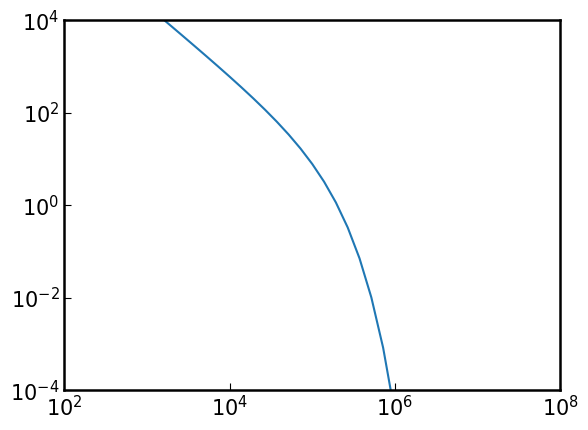

In [366]:
# https://ui.adsabs.harvard.edu/abs/2019ApJ...883..139S/abstract
# What sets the break? Transfer from radiatively efficient to inefficient accretion?
M_BH = np.logspace(1, 8)
phi = 10**np.random.normal(5, 0.3)
M_BH_br = 1e5
alpha = -1.5
phi = np.exp(-M_BH/M_BH_br)/M_BH_br * phi*(M_BH/M_BH_br)**alpha
plt.loglog(M_BH, phi/np.diff(np.log10(M_BH))[0])
plt.ylim(1e-4, 1e4)
plt.xlim(1e2, 1e8)

In [350]:
# Split into different mass ranges and vary eta

# Get phi in each bin but have varying eta in each bin, 100, 100, 10, 10, 1, 1, 1, 1

### Sample grid of SEDs

In [351]:
if not load:
    for key in keys:
        models[key].sample_sed_grid(band=bands[key], save_fits=False, load_fits=True)

Setting up model SED
Creating SED grid in band GROUND_COUSINS_R
Sampling SEDs with seeding mechanism light


  0%|          | 0/2 [00:00<?, ?it/s]

/home/colinjb2/.local/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Sampling SEDs with seeding mechanism heavy


  0%|          | 0/2 [00:00<?, ?it/s]

Sampling SEDs with seeding mechanism light_stellar


  0%|          | 0/2 [00:00<?, ?it/s]

### Mock Observations: light curves

PTF:

In [352]:
from model import pm_prec

# Magnitude model parameters
pm_prec_model = {}
m_5 = {'ptf':20.5, 'lsst':25.0, 'des-sn':24.5} # 20.5
m_sat = {'ptf':14.0, 'lsst':16.0, 'des-sn':18}
gamma = {'ptf':0.035, 'lsst':0.039, 'des-sn':0.024}

# Survey parameters
num_seasons = {'ptf':4, 'lsst':1, 'des-sn':6} # doesn't matter so much
season_duration = {'ptf':95, 'lsst':95, 'des-sn':95}
cadence = {'ptf':5, 'lsst':25, 'des-sn':7}

# Compute times
t_obs = {}
for key in keys:
    t_obs[key] = [np.arange(365*i, 365*i + season_duration[key], cadence[key]) for i in range(num_seasons[key])]
    t_obs[key] = np.array(t_obs[key]).flatten()

# Get uncertainties from photometric precision model
if key == 'ptf':
    pm_prec_model[key] = lambda x: pm_prec(x, gamma=gamma[key], m_5=21.5)
else:
    pm_prec_model[key] = lambda x: pm_prec(x, gamma=gamma[key], m_5=m_5[key])

In [353]:
band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}

labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}

In [354]:
if not load:
    for key in keys:
        # TODO: speed up using taofit?
        models[key].sample_light_curves(t_obs[key], band=bands[key], m_5=m_5[key],
                                        SFinf_small=1e-8, pm_prec=pm_prec_model[key])

Sampling light curves with seeding mechanism light


  0%|          | 0/2 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:1298: RuntimeWarning: divide by zero encountered in log10
  m_band_AGN = -2.5*np.log10(f_lambda_band_AGN.value) - lib[band].AB_zero_mag # (R)
/home/colinjb2/forecast/model.py:1299: RuntimeWarning: divide by zero encountered in log10
  r_band_host = -2.5*np.log10(f_lambda_band_host.value) - lib[band_r].AB_zero_mag # (r)
/home/colinjb2/forecast/model.py:1334: RuntimeWarning: divide by zero encountered in log10
  m_band = -2.5*np.log10(f_lambda_band.value) - lib[band].AB_zero_mag
/home/colinjb2/.local/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Sampling light curves with seeding mechanism heavy


  0%|          | 0/2 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:1343: RuntimeWarning: divide by zero encountered in log10
  M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
/home/colinjb2/forecast/model.py:641: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9)) # + np.random.normal(0, 0.09, size=len(M_BH))) # Delta mag
/home/colinjb2/forecast/model.py:641: RuntimeWarning: invalid value encountered in add
  D*np.log10(M_BH/1e9)) # + np.random.normal(0, 0.09, size=len(M_BH))) # Delta mag
/home/colinjb2/forecast/model.py:649: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9)) # Delta mag
/home/colinjb2/forecast/model.py:649: RuntimeWarning: invalid value encountered in add
  D*np.log10(M_BH/1e9)) # Delta mag
/home/colinjb2/forecast/model.py:662: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days
/home/colinjb2/forecast/model.py:662: RuntimeWarning: invalid value encountered in add
  D*np.lo

Sampling light curves with seeding mechanism light_stellar


  0%|          | 0/2 [00:00<?, ?it/s]

### Save results

In [355]:
if not load:
    for key in keys:
        models[key].save(survey=key)

LSST:

DES-SN

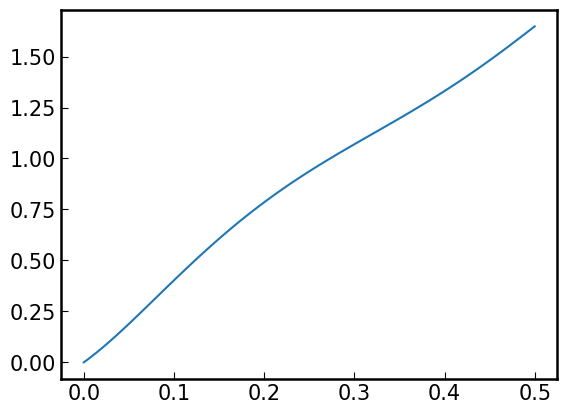

In [356]:
from numpy.polynomial.polynomial import polyval2d

c = [[0,         0,        0,         0],
         [-0.900332, 3.97338,  0.774394, -1.09389],
         [3.65877,  -8.04213,  11.0321,   0.781176],
         [-16.7457, -31.1241, -17.5553,   0],
         [87.3565,  71.5801,   0,         0],
         [-123.671, 0,         0,         0]]
    
z = np.linspace(0, 0.5, 100)
_colors = np.full(np.shape(z), 1.4)
K = polyval2d(z, _colors, c) # z, colors
plt.plot(z, K)

LSST hybrid

In [357]:
special = False

if 'lsst' in keys and special:

    # LSST Special
    num_seasons = 1
    season_duration = 5 # days
    cadence = 0.1 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()
    
    num_seasons = 10
    season_duration = 95 # days
    cadence = 25 # days
    t_obs2 = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs2 = np.array(t_obs2).flatten()
    
    t_obs = np.sort(np.concatenate([t_obs, t_obs2]))

    models['lsst'].sample_light_curves(t_obs, band=bands['lsst'],  dt_min=0.1/2)

In [358]:
pars = {}
#samples = {}
for key in keys:
    pars[key] = models[key].pars
    #samples[key] = models[key].samples

#np.save('s_lsst.npy', s_lsst)
#np.save('s_ptf.npy', s_ptf)

### Sanity checks

In [359]:
def plot_survey(plotting_function, survey_keys, pars, figdir='./figures', fig=None, savename=None, forcemajorticks=True, **argv):
    
    """
    Generalized plotting function
    """
    
    import matplotlib

    # model survey loop
    for k, survey in enumerate(survey_keys):
                
        if fig is None:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            axs = [ax]
        
        band = bands[key]
        seed_keys = list(pars[key]['seed_keys'])

        for i, seed in enumerate(seed_keys):
            
            fig, axs = plotting_function(fig, fig.axes, k, survey, i, seed, **argv)
            
        for ax in axs:
            if forcemajorticks:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
            ax.tick_params(axis='both', which='major', length=6)
            ax.tick_params(axis='both', which='minor', length=3)
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')
            ax.tick_params(axis='x', which='major', pad=7)
            
            if ax.get_xaxis().get_scale() == 'log':
                locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
                ax.xaxis.set_major_locator(locmaj)
                locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
                ax.xaxis.set_minor_locator(locmin)
                ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())            

        fig.tight_layout()
        if savename is not None:
            fig.savefig(os.path.join(figdir, f'{savename}_{key}.pdf'), dpi=300)
        
    return

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


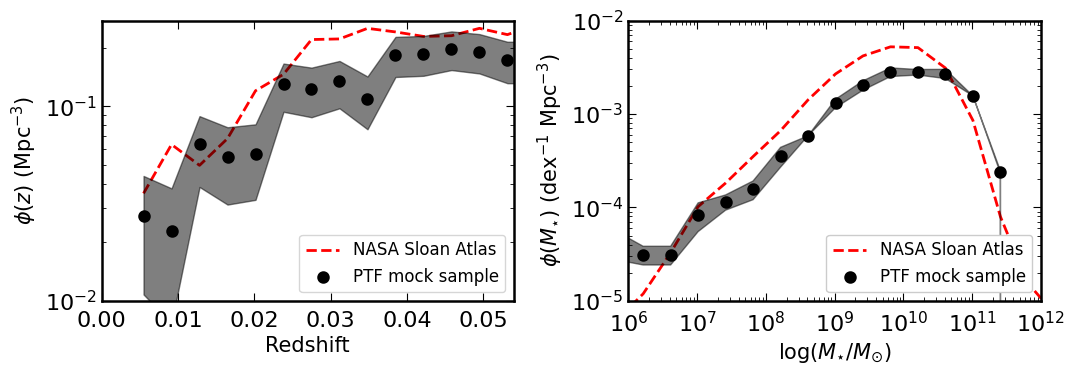

In [360]:
def plot_redshift_comparison(fig, axs, k, key, i, seed, band):
    
    # Only do 1st seed scenario
    if i > 0:
        return fig, axs
    
    from model import hist1d
    
    ndraw = int(np.max(pars[key]['ndraws']))
    eta = etas[key]
    g = 17.8
    g_minus_r = 0.5
    R = g - 0.1837*g_minus_r - 0.0971
    
    M_star_ = pars[key]['M_star_']
    M_star = pars[key]['M_star']
    dlogM_star = np.diff(np.log10(M_star.value))[0]

    z_ = np.linspace(0, pars[key]['zmax'], 16)
    dz = np.diff(z_)
    z = z_[1:] + dz/2
    
    n_i_M_5 = np.full([nbootstrap, nbins], np.nan, dtype=np.int)
    n_i_M = np.full([nbootstrap, nbins], np.nan, dtype=np.int)
    
    # SDSS
    stellar_mass = data_nsa['MASS'] * (0.7)**2

    mask_na_nsa = np.isfinite(data_nsa['Z']) & np.isfinite(stellar_mass)
    mask_mag_nsa = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) < g

    n_z_nsa, _ = np.histogram(data_nsa['Z'][mask_mag_nsa & mask_na_nsa], bins=z_)
    n_M_nsa, _ = np.histogram(stellar_mass[mask_mag_nsa & mask_na_nsa], bins=M_star_.value)

    axs[0].plot(z, n_z_nsa/dz/V, color='r', zorder=0,
                 linestyle='dashed', lw=2, label='NASA Sloan Atlas')
    axs[1].plot(M_star.value, n_M_nsa/dlogM_star/V, color='r', zorder=0,
             linestyle='dashed', lw=2, label='NASA Sloan Atlas')

    # Mock sample
    for j in range(nbootstrap):
    
        M_star_draw = models[key].load_sample(f'M_star_draw', j=j)
        z_draw = models[key].load_sample('z_draw', j=j)
        mag = models[key].load_sample(f'm_{band}', seed, j=j)
        pop = models[key].load_sample(f'pop', j=j)

        mask_mag = mag < R
        mask_gal = pop < 2
        mask_na = np.log10(M_star_draw) > 0
        n_i_M_5[j,:], _ = hist1d(M_star_draw[mask_gal & mask_mag & mask_na], bins=M_star_.value)
        n_i_M[j,:], _ = hist1d(M_star_draw[mask_gal & mask_mag & mask_na], bins=M_star_.value)
        
        # Redshift is the same for all j
        if j == 0:
            z_draw = models[key].load_sample('z_draw', j=j)
            n_z, _ = np.histogram(z_draw[mask_mag & mask_na], bins=z_)
            phi_z = (n_z/dz/V*eta).value
            axs[0].scatter(z, phi_z, lw=3, color='k', label='PTF mock sample')
            lo = phi_z - np.sqrt(phi_z/eta)
            hi = phi_z + np.sqrt(phi_z/eta)
            axs[0].fill_between(z, lo, hi, color='k', alpha=0.5)
            
    # Plot sample
    axs[1].fill_between(M_star.value, (np.nanpercentile(n_i_M_5, 16, axis=0)/dlogM_star/V).value*eta,
                        (np.nanpercentile(n_i_M_5, 84, axis=0)/dlogM_star/V).value*eta, color='k', alpha=0.5)
    axs[1].scatter(M_star.value, np.nanmean(n_i_M_5, axis=0)/dlogM_star/V*eta, lw=3, color='k', label='PTF mock sample')

    axs[0].set_ylim([1e-2, None])
    axs[1].set_ylim([1e-5, 1e-2])
    axs[0].set_xlim([0, 0.054])
    axs[1].set_xlim([1e6, 1e12])

    axs[0].set_ylabel(r'$\phi(z)$ (Mpc$^{-3}$)')
    axs[1].set_ylabel(r'$\phi(M_{\star})$ (dex$^{-1}$ Mpc$^{-3}$)')

    axs[0].set_xlabel(r'Redshift')
    axs[1].set_xlabel(r'$\log(M_{\star}/M_{\odot})$')

    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')

    #if i == nbootstrap - 1:
    axs[0].legend(fontsize=12, loc='lower right')
    legend = axs[1].legend(fontsize=12, loc='lower right')
    legend.get_frame().set_alpha(None)
    
    return fig, axs

fig, axs = plt.subplots(1, 2, figsize=(2*5.5, 4))
plot_survey(plot_redshift_comparison, keys, pars, fig=fig, band=bands[key], savename='redshiftmasscomparison')

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in subtract
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in subtract


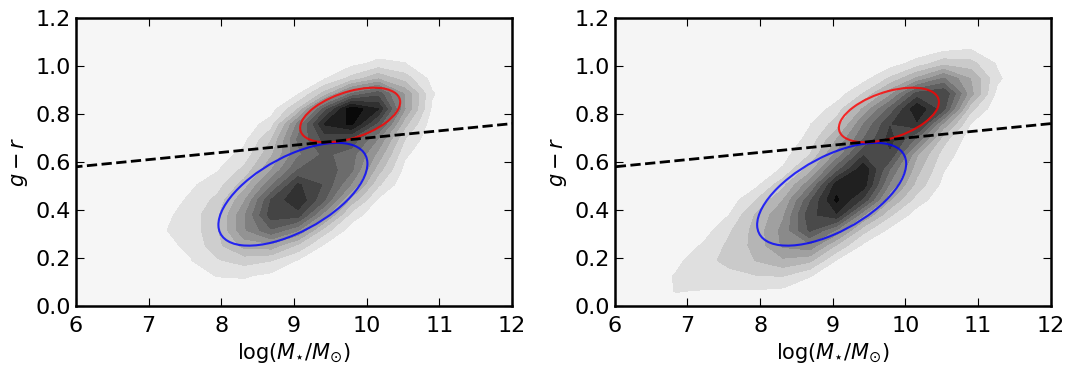

In [361]:
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

def plot_results(X, Y_, means, covariances, index, ax=None, title=None, colors=['b','r','k'], alphas=None):
    #splot = plt.subplot(2, 1, 1 + index)
    ax = ax or plt.gca()
    
    if alphas is None: alphas = np.ones(len(means))
    color_iter = itertools.cycle(colors)
    
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        if X is not None:
            ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color, zorder=-100)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, fc='none', lw=1.5, ec=color)
        
        ell.set_clip_box(plt.gcf().bbox)
        ell.set_alpha(alphas[i])
        ax.add_artist(ell)

    ax.set_title(title)

def plot_color_comparison(fig, axs, k, key, i, seed, band, j=0):

    # Colors are identical for all seeding scenarios
    if i > 0:
        return fig, axs

    # Data
    g = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) # g
    r = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,4]) # r
    stellar_mass = data_nsa['MASS'] * (0.7)**2

    # GMM
    thin = 10
    mask_nan = np.isfinite(g-r) & np.isfinite(np.log10(stellar_mass))
    #mask_outlier = (np.log10(stellar_mass) > 6) & (np.log10(stellar_mass) < 12) & ((g-r) > 0) & ((g-r) < 1.2)

    x = np.log10(stellar_mass[mask_nan])[::thin]
    y = (g-r)[mask_nan][::thin]
    X = np.array([x, y]).T

    gmm = BayesianGaussianMixture(n_components=3, covariance_type="full", random_state=1).fit(X)
    labels = gmm.predict(X)

    xx, yy = np.mgrid[5:12:20j, 0:1.2:20j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = axs[0].contourf(xx, yy, f, levels=12, cmap='binary')

    # mock sample
    ndraw_dim = int(np.max(pars[key]['ndraws']))

    stellar_mass = models[key].load_sample(f'M_star_draw', j=j)
    g_minus_r = models[key].load_sample(f'g-r', j=j)
    pop = models[key].load_sample(f'pop', j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)

    # SDSS detection limit
    mask_nan = np.isfinite(np.log10(stellar_mass)) & np.isfinite(g_minus_r) & (pop < 2)
    mask_mag = (mag < 18.5) & (mag > 14)

    x = np.log10(stellar_mass[mask_nan & mask_mag]) #[::thin]
    y = g_minus_r[mask_nan & mask_mag] #[::thin]

    xx, yy = np.mgrid[5:12:20j, 0:1.2:20j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = axs[1].contourf(xx, yy, f, levels=12, cmap='binary')


    for ax in axs:
        ax.set_ylim([0.0, 1.2])
        ax.set_xlim([6, 12])

        # Plot contours
        plot_results(None, gmm.predict(X), gmm.means_, gmm.covariances_, 0, ax=ax, alphas=[0.8, 0.8, 0], colors=['b','r','k'])

        # Bell 2003 slope
        x_eval = np.linspace(4, 13)
        ax.plot(x_eval, 0.03*x_eval + 0.4, lw=2, color='k', linestyle='dashed')

        ax.set_ylabel(r'$g - r$')
        ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')

        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', which='major', pad=7)

    return fig, axs

fig, axs = plt.subplots(1, 2, figsize=(2*5.5, 4))
plot_survey(plot_color_comparison, keys, pars, fig=fig, band=bands[key], savename='color')

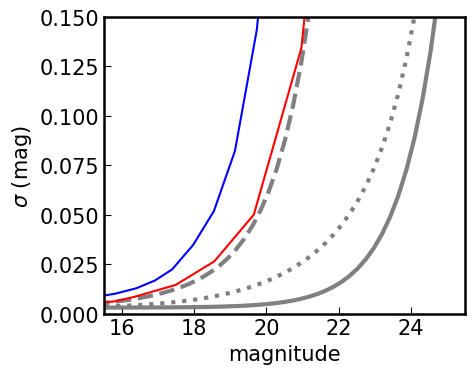

In [362]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(14, 25)

pm_prec_lsst = pm_prec(m_eval, gamma=gamma['lsst'], m_5=m_5['lsst'])
pm_prec_ptf = pm_prec(m_eval, gamma=gamma['ptf'], m_5=21.5)
pm_prec_des = pm_prec(m_eval, gamma=gamma['des-sn'], m_5=m_5['des-sn'])

# 5-sigma limiting depth increases with ~sqrt(len(t_obs)*0.3) frames, assuming 30% of the images are used for the template.


ax.plot(m_eval, pm_prec_lsst, color='gray', lw=3)
ax.plot(m_eval, pm_prec_ptf, color='gray', lw=3, linestyle='dashed')
ax.plot(m_eval, pm_prec_des, color='gray', lw=3, linestyle='dotted')

# https://iopscience.iop.org/article/10.1086/664065/meta
dat = np.loadtxt('ptf_pmp.txt', delimiter=',')
m = dat[:,0]
dm = dat[:,1]
ax.plot(m, dm, color='b')

dat = np.loadtxt('test.txt', delimiter=',')
m = dat[:,0]
dm = dat[:,1]
ax.plot(m, 10**dm, color='r') # variable shit is roughly above this line in BGG20


ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, .15)
ax.set_ylabel(r'$\sigma$ (mag)')
ax.set_xlabel(r'magnitude')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


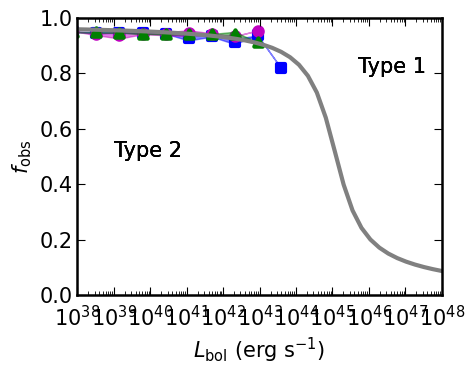

In [363]:
from model import lambda_obs
import matplotlib

def plot_obs(fig, axs, k, key, i, seed, band, j=0, n_bin_min=5):
    
    L_bol_ = np.logspace(36, 48, nbins)
    
    if i == 0:
        L_bol_eval = np.logspace(36, 48)
        ax.semilogx(L_bol_eval, 0.98*lambda_obs(L_bol_eval, randomize=False), color='gray', lw=3)


    nbootstrap = pars[key]['nbootstrap']
    f = np.full([nbootstrap, len(L_bol_)-1], np.nan)

    for j in range(nbootstrap):

        L_bol_draw = models[key].load_sample(f'L_draw', seed, j=j)
        L_band = models[key].load_sample(f'L_{band}', seed, j=j)

        mask_nan = L_bol_draw > 0

        # Compute fraction
        bin_ct, bin_edges, _ = st.binned_statistic(L_bol_draw[mask_nan & (L_band>0)],
                                                   L_bol_draw[mask_nan & (L_band>0)], 'count', bins=L_bol_)
        bin_tot, bin_edges, _ = st.binned_statistic(L_bol_draw[mask_nan], L_bol_draw[mask_nan],
                                                    'count', bins=L_bol_)
        mask = bin_ct > n_bin_min
        f[j][mask] = 1 - bin_ct[mask]/bin_tot[mask]

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    ax.scatter(bin_centers, np.nanmedian(f, axis=0), zorder=0, lw=3, color=colors[seed], marker=markers[seed])
    ax.fill_between(bin_centers, np.nanpercentile(f, 84, axis=0), np.nanpercentile(f, 16, axis=0),
                    zorder=0, color=colors[seed], alpha=0.5)


    ax.text(0.1, 0.5, 'Type 2', transform=ax.transAxes)
    ax.text(0.77, 0.8, 'Type 1', transform=ax.transAxes)


    ax.set_xlim(1e38, 1e48)
    ax.set_ylim(0, 1)
    ax.set_ylabel(r'$f_{\rm{obs}}$')
    ax.set_xlabel(r'$L_{\rm{bol}}$ (erg s$^{-1}$)')

    return fig, [ax]


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_survey(plot_obs, keys, pars, fig=fig, forcemajorticks=False, band=bands[key], savename='obs')

### Variability analysis

In [ ]:
import celerite
from celerite import terms
from scipy.optimize import minimize

def fit_drw(x, y, yerr):
    
    # Sort data
    ind = np.argsort(x)
    x = x[ind]; y = y[ind]; yerr = yerr[ind]
    baseline = x[-1]-x[0]
    
    min_precision = np.min(yerr.value)
    amplitude = np.max(y.value+yerr.value)-np.min(y.value-yerr.value)
    amin = np.log(0.001*min_precision)
    amax = np.log(10*amplitude)
    log_a = np.mean([amin,amax])

    min_cadence = np.clip(np.min(np.diff(x.value)), 1e-8, None)
    cmin = np.log(1/(10*baseline.value))
    cmax = np.log(1/min_cadence)
    log_c = np.mean([cmin,cmax])

    smin = -10
    smax = np.log(amplitude)
    log_s = np.mean([smin,smax])
    
    # Kernel
    kernel = terms.RealTerm(log_a=log_a, log_c=log_c,
                            bounds=dict(log_a=(amin, amax), log_c=(cmin, cmax)))
    
    # Add jitter term
    kernel += terms.JitterTerm(log_sigma=log_s, bounds=dict(log_sigma=(smin, smax)))
    
    # Find MLE
    gp = celerite.GP(kernel, mean=np.mean(y.value), fit_mean=True)
    gp.compute(x.value, yerr.value)

    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
        
    # MLE solution
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y.value, gp))
    initial = np.array(soln.x)
        
    return initial

### Variability-selection histograms

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


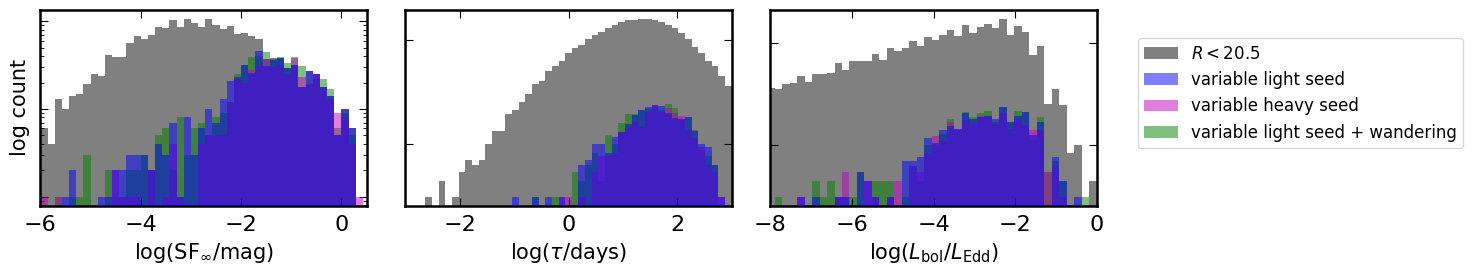

In [290]:
def plot_varhist(fig, axs, k, key, i, seed, band, j=0):

    band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}
    labels_legend = ['light seed', 'heavy seed', 'light seed + wandering']

    nbootstrap = pars[key]['nbootstrap']

    bins = np.linspace(-6, 1)

    SF = models[key].load_sample(f'SFinf_{band}', seed, j=j)
    tau = models[key].load_sample(f'tau_RF_{band}', seed, j=j)
    lambda_Edd = models[key].load_sample(f'lambda_draw', j=j)
    L_draw = models[key].load_sample(f'L_draw', seed, j=j)
    M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)
    sigvar = models[key].load_sample(f'sigvar', seed, j=j)


    mask_nan = np.isfinite(SF) & np.isfinite(tau)
    mask_mass = M_BH > 1e2
    mask_mag = mag < m_5[key]
    mask_var = sigvar > 2
    mask_sat = mag > m_sat[key]

    if i == 0:
        axs[0].hist(np.log10(SF[mask_mass & mask_mag & mask_sat]), bins=bins,
                    color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
    axs[0].hist(np.log10(SF[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                color=colors[seed], label='variable', alpha=0.5, zorder=zorders[seed])

    axs[0].set_xlim(-6, 0.5)
    #ax.set_ylim(0, 1500)

    axs[0].set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
    axs[0].set_ylabel(r'log count')

    bins = np.linspace(-3, 3)
    if i == 0:
        axs[1].hist(np.log10(tau[mask_mass & mask_mag & mask_sat]), bins=bins,
                    color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
    axs[1].hist(np.log10(tau[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                color=colors[seed], label='variable', alpha=0.5, zorder=zorders[seed])
    axs[1].set_xlim(-3.0, 3.0)

    axs[1].set_xlabel(r'$\log(\tau / {\rm{days}})$')

    bins = np.linspace(-9, 0)
    if i == 0:
        axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_mag & mask_sat]), bins=bins,
                    color='gray', label=fr'${band_names[key]}<{m_5[key]}$', log=True)
    axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_var & mask_sat & mask_mag]), bins=bins,
                color=colors[seed], label='variable '+labels_legend[i], alpha=0.5, zorder=zorders[seed])
    axs[2].set_xlim(-8, 0)

    axs[2].set_xlabel(r'$\log(L_{\rm{bol}} / L_{\rm{Edd}})$')

    axs[2].legend(fontsize=12, bbox_to_anchor=(1.10, 0.9))

    for ax in axs:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.tick_params(axis=u'y', which=u'both',length=0)
        
    return fig, axs
                
                
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
plot_survey(plot_varhist, keys, pars, fig=fig, band=bands[key], savename='varhist')

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


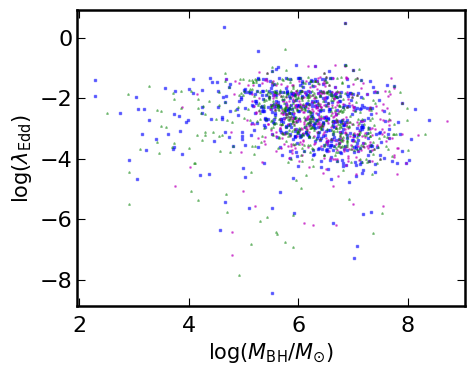

In [291]:
def plot_masslambda(fig, axs, k, key, i, seed, band, j=0, thin=1):
    
    labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
              'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
              'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
            
    lambda_Edd = models[key].load_sample(f'lambda_draw', j=j)
    M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)
    sigvar = models[key].load_sample(f'sigvar', seed, j=j)
    pop = models[key].load_sample(f'pop', j=j)

    mask_mass = M_BH > 1e2
    mask_mag = mag < m_5[key]
    mask_sat = mag > m_sat[key]
    mask_var = (sigvar > 2)
    mask_pop = pop < 2

    ax.scatter(np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag][::thin],
               np.log10(lambda_Edd)[mask_mass & mask_var & mask_sat & mask_mag][::thin],
               color=colors[seed], marker=markers[seed], alpha=0.5, s=1)

    ax.set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
    ax.set_ylabel(r'$\log(\lambda_{\rm{Edd}})$')

    return fig, axs
            
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_survey(plot_masslambda, keys, pars, fig=fig, band=bands[key], savename='masslambda')

### Recovered $\tau$

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

cadence = 0

def plot_tau():

    for k, (key, s) in enumerate(samples.items()):

        fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

        nbootstrap = pars[key]['nbootstrap']
        band = bands[key]
        seed_keys = list(pars[key]['seed_keys'])
        print(key)

        for j in range(1): ## Just use the first bootstrap

            for i, seed in enumerate(seed_keys):

                ndraw_dim = int(np.max(s['ndraws']))

                mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
                mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > cadence
                mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+5)
                mask_var = s[f'sigvar_{seed}'][j,:ndraw_dim] > 2
                mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

                tau_rest = s[f'tau_{seed}'][j,:ndraw_dim]/(1 + s[f'z_draw'][j,:ndraw_dim])
                M_BH = 10**7.97*(tau_rest/100)**2.54

                ax.scatter(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag & mask_tau]),
                           np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag & mask_tau],
                           color=colors[i], s=2, zorder=1, alpha=0.5)

                pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
                #ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
                ax.plot([0, 9], [0, 9], lw=2, color='gray', zorder=0)
                M_cadence = 10**7.97*(cadence/100)**2.54
                #ax.plot([0, 9], [np.log10(M_cadence), np.log10(M_cadence)], lw=2, color='gray', linestyle='dashed', zorder=0)

                rmse_val = rmse(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag]),
                                np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag])
            #ax.text(2.2, 8.3, f'{cadence} day cadence', color='black', fontsize=14)
            ax.text(2.2, 8.3, f'hybrid cadence', color='black', fontsize=14)


        #ax.set_xlim([m_sat[key], m_5[key]])
        ax.set_xlabel(r'Input $\log(M_{\rm{BH}} / M_{\odot})$')
        ax.set_ylabel(r'Recovered $\log(M_{\rm{BH}} / M_{\odot})$')
        ax.set_xlim(2, 9)
        ax.set_ylim(2, 9)
        fig.tight_layout()
        fig.savefig(f'var_{key}_3_25.pdf', dpi=300)
    

### Recovered variability relations

In [ ]:
# Can we recover the MacLeod variability relations using SDSS-like light curves and infer the input variaiblity?
# The tau relations are probably not strongly biased, but the SFinf ones probably are
# There is a population of (low-luminosity) quasars with small SF_infty that can't be detected, so this let's us "fine-tune"
# the normalization of A in this equation

### rms - magnitude diagram

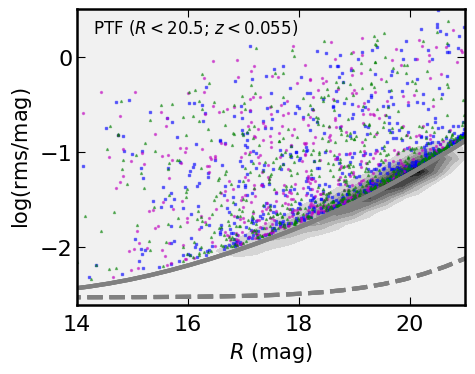

In [292]:
def plot_rms(fig, axs, k, key, i, seed, band, j=0, thin=1):
    
    band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}
    labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}

    # Read Baldassare 
    """
    dat = np.loadtxt('test.txt', delimiter=',')
    m = dat[:,0]
    dm = dat[:,1]
    """
    
    ax = axs[0]
    
    m_eval = np.linspace(12, 30)

    nbootstrap = pars[key]['nbootstrap']

    M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)
    std = models[key].load_sample(f'std', seed, j=j)
    sigvar = models[key].load_sample(f'sigvar', seed, j=j)
    pop = models[key].load_sample(f'pop', j=j)

    mask_mass = M_BH > 1e2
    mask_mag = mag < m_5[key]
    mask_var = sigvar > 2
    mask_sat = mag > m_sat[key]
    mask_pop = pop < 2
    
    if i == 0:
        x = mag[mask_mass & mask_mag & mask_sat & mask_pop]
        y = np.log10(std[mask_mass & mask_mag & mask_sat & mask_pop])

        mask = np.isfinite(x) & np.isfinite(y)
        x = x[mask]
        y = y[mask]

        # Peform the kernel density estimate
        xx, yy = np.mgrid[14:m_5[key]+2:30j, -3:1:30j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        # Contourf plot
        cfset = ax.contourf(xx, yy, f, levels=8, cmap='binary')
        
        # Label
        ax.text(0.04, 0.92, labels[key], fontsize=12, transform=ax.transAxes)

    # Variable
    ax.scatter(mag[mask_mass & mask_var & mask_sat][::thin],
               np.log10(std[mask_mass & mask_var & mask_sat][::thin]),
               color=colors[seed], marker=markers[seed], s=2, zorder=1, alpha=0.5)

    if key == 'ptf':
        pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=21.5)
        g_minus_r = 0.5
        g_eval = -( - 0.1837*g_minus_r - 0.0971 - m_eval)
        pm_prec_lsst_g = pm_prec(g_eval, gamma=gamma['lsst'], m_5=m_5['lsst'])
        ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
        ax.plot(g_eval, np.log10(pm_prec_lsst_g), color='gray', lw=3, linestyle='dashed')
    else:
        pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
        g_minus_r = 0.5
        R_eval = m_eval - 0.1837*g_minus_r - 0.0971
        pm_prec_ptf_R = pm_prec(R_eval, gamma=gamma['ptf'], m_5=m_5['ptf'])
        ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
        ax.plot(R_eval, np.log10(pm_prec_ptf_R), color='gray', lw=3, linestyle='dashed')

    #ax.plot(m, dm)

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.set_xlim([m_sat[key], m_5[key]+0.5])
    ax.set_ylabel(r'$\log(\rm{{rms}} / {\rm{mag}})$')
    ax.set_xlabel(fr'${band_names[key]}$ (mag)')
    ax.set_ylim(-2.6, 0.5)
        
    return fig, [ax]
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_survey(plot_rms, keys, pars, fig=fig, band=bands[key], savename='rmsmag')

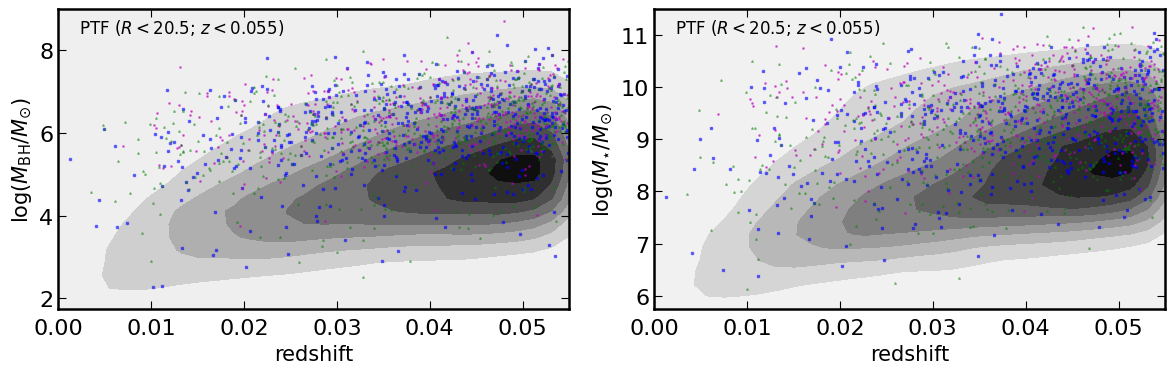

In [293]:
def plot_massredshift(fig, axs, k, key, i, seed, band, j=0, logmass_sys_err=0.3, thin=1):
    
    labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
              'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
              'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}

    nbootstrap = pars[key]['nbootstrap']

    SF = models[key].load_sample(f'SFinf_{band}', seed, j=j)
    tau = models[key].load_sample(f'tau_RF_{band}', seed, j=j)
    lambda_Edd = models[key].load_sample(f'lambda_draw', j=j)
    L_draw = models[key].load_sample(f'L_draw', seed, j=j)
    M_BH_all = models[key].load_sample(f'M_BH_draw', j=j)
    M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
    M_star = models[key].load_sample(f'M_star_draw', j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)
    sigvar = models[key].load_sample(f'sigvar', seed, j=j)
    z = models[key].load_sample('z_draw', j=0)
    pop = models[key].load_sample(f'pop', j=j)

    mask_mass = M_BH > 1e2
    mask_mass_all = M_BH_all > 1e2
    mask_mag = mag < m_5[key]
    mask_sat = mag > m_sat[key]
    mask_var = (sigvar > 2)
    mask_pop = pop < 2

    x = z[mask_mass_all & mask_mag & mask_sat & mask_pop]
    y = np.log10(M_BH_all)[mask_mass_all & mask_mag & mask_sat & mask_pop]

    if i == 0:
        # Peform the kernel density estimate
        xx, yy = np.mgrid[0:pars[key]['zmax']:30j, 1:10:30j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        # Contourf plot
        cfset = axs[0].contourf(xx, yy, f, levels=10, cmap='binary')

        #axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_sat],
        #               np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_sat],
        #               color='gray', s=1, zorder=5)

    axs[0].scatter(z[mask_mass & mask_var & mask_sat & mask_mag][::thin],
                   np.log10(M_BH_all)[mask_mass & mask_var & mask_sat & mask_mag][::thin],
                   color=colors[seed], marker=markers[seed], alpha=0.5, s=1)

    axs[0].set_ylim(1.75, 9)
    #axs[0].set_xlim(0, s['zmax'])
    axs[0].set_xlabel(r'redshift')
    axs[0].set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')

    if i==0:
        axs[0].text(0.04, 0.92, labels[key], fontsize=12, transform=axs[0].transAxes)

    x = z[mask_mass_all & mask_mag & mask_sat & mask_pop]
    log_M_star = np.log10(M_star)
    log_M_star += np.random.normal(0, logmass_sys_err, size=np.shape(log_M_star))

    y = log_M_star[mask_mass_all & mask_mag & mask_sat & mask_pop]

    if i == 0:
        # Peform the kernel density estimate
        xx, yy = np.mgrid[0:pars[key]['zmax']:30j, 5:12:30j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

        cfset = axs[1].contourf(xx, yy, f, levels=10, cmap='binary')

    axs[1].scatter(z[mask_mass & mask_var & mask_sat & mask_mag][::thin],
                   log_M_star[mask_mass & mask_var & mask_sat & mask_mag][::thin],
                   color=colors[seed], marker=markers[seed], alpha=0.5, s=1)

    axs[1].set_ylim(5.75, 11.5)
    #axs[1].set_xlim(0, s['zmax'])
    #axs[1].set_yscale('log')
    axs[1].set_xlabel(r'redshift')
    axs[1].set_ylabel(r'$\log(M_{\star}/M_{\odot})$')

    if i == 0:
        axs[1].text(0.04, 0.92, labels[key], fontsize=12, transform=axs[1].transAxes)

    #ax.legend(fontsize=12)

    for ax in axs:
        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')

    return fig, axs

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
plot_survey(plot_massredshift, keys, pars, fig=fig, band=bands[key], savename='massredshift')

In [294]:
## NSA limit is R ~ 17.7, but PTF limit is R ~20.5 - 21.5

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: Runt

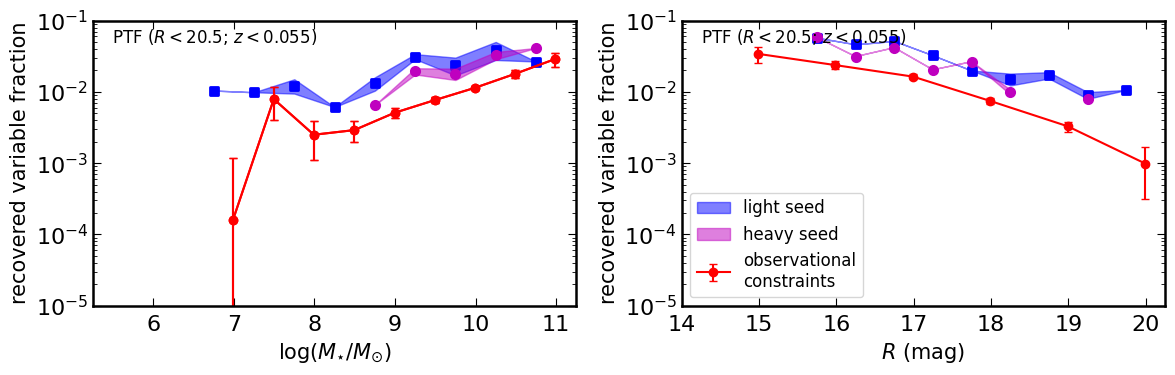

In [364]:
def plot_varfrac(fig, axs, k, key, i, seed, band, j=0, logmass_sys_err=0.3, n_bin_min=3, thin=1):

    labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
              'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
              'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
    band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}

    labels_legend = {'light':'light seed', 'heavy':'heavy seed','light_stellar':'light seed + wandering',
                     'a':r'$\lambda_{\mathcal{A}} \propto (\log{M_{\star}})^{4.5}$'}

    # are dominated by uncertainties in stellar evolution (Conroy et al. 2009).

    nbootstrap = pars[key]['nbootstrap']

    # Don't plot the wandering population, don't know how it's connected to host stellar mass
    if '_stellar' in seed.lower():
        return fig, axs

    bins_mass = np.arange(5, 12, 0.5)
    bins_mag = np.arange(14, m_5[key], 0.5)

    f_mass = np.full([nbootstrap, len(bins_mass)-1], np.nan)
    f_mag = np.full([nbootstrap, len(bins_mag)-1], np.nan)

    for j in range(nbootstrap):
        ndraw = int(pars[key]['ndraws'][j])

        M_BH_all = models[key].load_sample(f'M_BH_draw', j=j)
        M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
        M_star_all = models[key].load_sample(f'M_star_draw', j=j)
        mag = models[key].load_sample(f'm_{band}', seed, j=j)
        sigvar = models[key].load_sample(f'sigvar', seed, j=j)
        pop = models[key].load_sample(f'pop', j=j)

        log_M_BH = np.log10(M_BH)
        log_M_BH_all = np.log10(M_BH_all)
        log_M_star_all = np.log10(M_star_all)

        log_M_star_all += np.random.normal(0, logmass_sys_err, size=np.shape(M_star_all))

        mask_var = sigvar > 2
        mask_mag = mag < m_5[key]
        mask_sat = mag > m_sat[key]
        mask_mass = M_BH > 1e2
        mask_mass_all = M_BH_all > 1e2
        mask_pop = pop < 2

        # mass
        m_star_bin = log_M_star_all[mask_mag & mask_sat & mask_pop]
        bin_count, bin_edges_mass, binnumber = st.binned_statistic(m_star_bin[::thin], m_star_bin[::thin],
                                                              statistic='count', bins=bins_mass)
        bin_count = bin_count*thin
        m_star_bin = log_M_star_all[mask_mass & mask_var & mask_sat]
        bin_count_var, bin_edges_mass, binnumber = st.binned_statistic(m_star_bin, m_star_bin,
                                                                  statistic='count', bins=bins_mass)
        mask = bin_count_var > n_bin_min
        f_mass[j][mask] = bin_count_var[mask]/bin_count[mask]
        bin_width_mass = (bin_edges_mass[1] - bin_edges_mass[0])
        bin_centers_mass = bin_edges_mass[1:] - bin_width_mass/2

        # mag
        mag_bin = mag[mask_mag & mask_sat]
        m_star_bin = log_M_star_all[mask_mag & mask_sat & mask_pop]
        bin_count, bin_edges_mag, binnumber = st.binned_statistic(mag_bin[::thin], m_star_bin[::thin],
                                                              statistic='count', bins=bins_mag)
        bin_count = bin_count*thin
        mag_bin = mag[mask_mass & mask_var & mask_sat & mask_mag] # & mask_qso]
        m_star_bin = log_M_star_all[mask_mass & mask_var & mask_sat & mask_mag]
        bin_count_var, bin_edges_mag, binnumber = st.binned_statistic(mag_bin, m_star_bin,
                                                                  statistic='count', bins=bins_mag)
        mask = bin_count_var > n_bin_min
        f_mag[j][mask] = bin_count_var[mask]/bin_count[mask]
        bin_width_mag = (bin_edges_mag[1] - bin_edges_mag[0])
        bin_centers_mag = bin_edges_mag[1:] - bin_width_mag/2

    # mass
    axs[0].fill_between(bin_centers_mass, np.nanpercentile(f_mass, 16, axis=0),
                        np.nanpercentile(f_mass, 84, axis=0),
                        color=colors[seed], alpha=0.5)
    axs[0].scatter(bin_centers_mass, np.nanmedian(f_mass, axis=0), lw=2, marker=markers[seed],
                   color=colors[seed])
    axs[0].set_ylabel('recovered variable fraction')
    axs[0].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')
    if i==0:
        axs[0].text(0.04, 0.92, labels[key], fontsize=12, transform=axs[0].transAxes)
    axs[0].set_xlim([np.min(bin_centers_mass), np.max(bin_centers_mass)])

    if key == 'ptf':
        from astropy.io import ascii
        dat = ascii.read('bgg20.txt')
        n = np.array([151, 519, 1313, 3237, 7467, 14052, 16367, 3188, 692, 155])[:-1]
        bgg_m = dat['col1'].data[:-1]
        bgg_f = dat['col2'].data[:-1]
        axs[0].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='r', capsize=3)


    # mag
    axs[1].fill_between(bin_centers_mag, np.nanpercentile(f_mag, 16, axis=0),
                        np.nanpercentile(f_mag, 84, axis=0),
                        color=colors[seed], alpha=0.5, label=labels_legend[seed])
    axs[1].scatter(bin_centers_mag, np.nanmedian(f_mag, axis=0), lw=2, marker=markers[seed],
                   color=colors[seed])
    axs[1].set_ylabel('recovered variable fraction')
    axs[1].set_xlabel(band_names[key])
    if i==0:
        axs[1].text(0.04, 0.92, labels[key], fontsize=12, transform=axs[1].transAxes)

    if i==0 and key == 'ptf':
        from astropy.io import ascii
        dat = ascii.read('bgg20_2.txt')
        n = np.array([409, 2520, 9881, 20261, 11523, 2159, 259])[:-1]
        bgg_m = dat['col1'].data[:-1]
        bgg_f = dat['col2'].data[:-1]
        axs[1].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o',
                        color='r', capsize=3, label='observational\n'+'constraints')

    axs[1].set_xlim([m_sat[key], np.max(bin_centers_mag)+0.5])


    axs[0].set_yscale('log')
    axs[1].set_yscale('log')

    axs[0].set_ylim([1e-5, 1e-1])
    axs[1].set_ylim([1e-5, 1e-1])

    axs[1].legend(fontsize=12, loc='lower left')
    
    return fig, axs

        
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_survey(plot_varfrac, keys, pars, fig=fig, band=bands[key], savename='varfrac')

The smaller variable fraction for fainter sources could be because of under-estimated error bars in the real light curves from sextractor. These tend to over-estimate the number of massive galaxies, which tend to be brighter. Or it's an assumption in our model.

We can see from BGG18 Figure 4, that the actual variability significance threshold is $\sim1\sigma$ plus the metric for AGN-like variability.

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


1282.5 161.5 161.5
4797.5 1905.6999999999998 1905.6999999999998
1282.5 161.5 161.5
4797.5 1905.6999999999998 1905.6999999999998


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


0.0 0.0 0.0
2422.5 742.9000000000001 742.9000000000001
0.0 0.0 0.0
2422.5 742.9000000000001 742.9000000000001
1187.5 161.5 161.5
4655.0 1808.8000000000002 1808.7999999999993
1187.5 161.5 161.5
4655.0 1808.8000000000002 1808.7999999999993


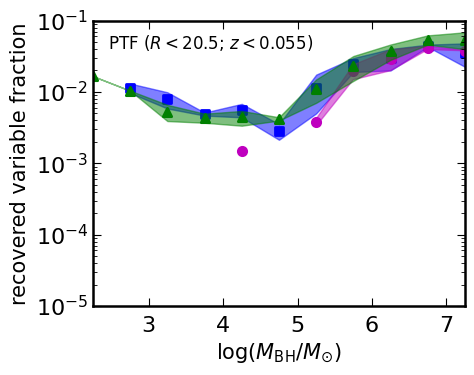

In [263]:
def plot_varfracbh(fig, axs, k, key, i, seed, band, j=0, logmass_sys_err=0.3, n_bin_min=1, thin=1):

    labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
              'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
              'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
    band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}

    nbootstrap = pars[key]['nbootstrap']
    count_imbh = np.zeros(nbootstrap)
    count_mbh = np.zeros(nbootstrap)
    
    ax = axs[0]

    bins = np.arange(2, 8.0, 0.5)
    f = np.full([nbootstrap, len(bins)-1], np.nan)

    for j in range(nbootstrap):

        M_BH_all = models[key].load_sample(f'M_BH_draw', j=j)
        M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
        M_star_all = models[key].load_sample(f'M_star_draw', j=j)
        mag = models[key].load_sample(f'm_{band}', seed, j=j)
        sigvar = models[key].load_sample(f'sigvar', seed, j=j)
        pop = models[key].load_sample(f'pop', j=j)

        log_M_BH = np.log10(M_BH)
        log_M_BH_all = np.log10(M_BH_all)
        log_M_star_all = np.log10(M_star_all)

        log_M_star_all += np.random.normal(0, logmass_sys_err, size=np.shape(M_star_all))

        mask_var = sigvar > 2
        mask_mag = mag < m_5[key]
        mask_sat = mag > m_sat[key]
        mask_mass = M_BH > 1e2
        mask_mass_all = M_BH_all > 1e2
        mask_pop = pop < 2


        mask_imbh = (M_BH < 1e4)
        mass_mbh = (M_BH > 1e4) & (M_BH < 1e6)
        count_imbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mask_imbh)
        count_mbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mass_mbh)

        m_bh_bin = log_M_BH_all[mask_mass_all & mask_mag & mask_sat]
        m_star_bin = log_M_star_all[mask_mag & mask_sat]
        bin_count, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                              statistic='count', bins=bins)
        m_bh_bin = log_M_BH[mask_mass & mask_var & mask_sat] # & mask_pop]
        bin_count_var, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                                  statistic='count', bins=bins)
        mask = bin_count_var > n_bin_min
        f[j][mask] = bin_count_var[mask]/bin_count[mask]
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        # Need to rescale total number of z<0.055 galaxies to 35,000 to match BGG20
        #axs[0].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    ax.fill_between(bin_centers, np.nanpercentile(f, 16, axis=0), np.nanpercentile(f, 84, axis=0),
                        color=colors[seed], alpha=0.5)
    #axs[0].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
    # There are some "simulation" noise here if eta is too large
    ax.scatter(bin_centers, np.nanmedian(f, axis=0), lw=2, color=colors[seed], marker=markers[seed])
    ax.set_ylabel('recovered variable fraction')
    ax.set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
    #axs[1].set_xlim([6, 11])
    if i == 0:
        ax.text(0.04, 0.90, labels[key], fontsize=12, transform=ax.transAxes)

    # Rescale:
    count_imbh = etas[key]*0.95*count_imbh
    count_mbh = etas[key]*0.95*count_mbh

    mean_imbh = np.mean(count_imbh, axis=0)
    mean_mbh = np.mean(count_mbh, axis=0)
    print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
    print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

    ax.set_yscale('log')
    ax.set_yscale('log')

    ax.set_ylim([1e-5, 1e-1])
    ax.set_xlim([np.min(bin_centers), np.max(bin_centers)])

    # Count results
    mean_imbh = np.mean(count_imbh, axis=0)
    mean_mbh = np.mean(count_mbh, axis=0)

    # N, -, + 
    print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
    print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

    return fig, [ax]
        
fig, axs = plt.subplots(1, 1, figsize=(5, 4))
plot_survey(plot_varfracbh, keys, pars, fig=fig, band=bands[key], savename='varfracbh')

(66,) (66,)
(179,) (179,)
(2,) (2,)


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: operands could not be broadcast together with shapes (66,) (179,) 

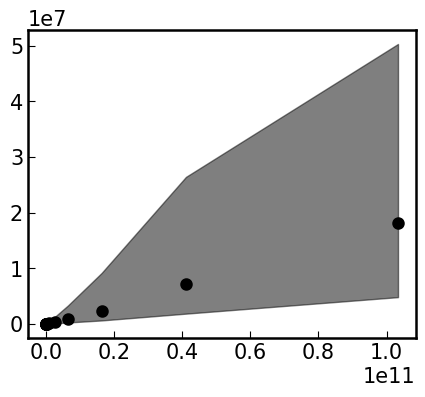

In [261]:
def plot_massbias(fig, axs, k, key, i, seed, band, j=0, logmass_sys_err=0.3, n_bin_min=1, thin=1):

    labels = {'ptf':r'PTF ($R < 20.5$; $z < 0.055$)', 'lsst':r'LSST ($g < 25.0$; $z < 0.055$)'}
    
    ax = axs[0]
            
    # Skip the wandering population
    if '_stellar' in seed:
        return fig, [ax]

    nbootstrap = pars[key]['nbootstrap']

    M_BH_all = models[key].load_sample(f'M_BH_draw', j=j)
    M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
    M_star_all = models[key].load_sample(f'M_star_draw', j=j)
    mag = models[key].load_sample(f'm_{band}', seed, j=j)
    sigvar = models[key].load_sample(f'sigvar', seed, j=j)
    pop = models[key].load_sample(f'pop', j=j)

    log_M_BH = np.log10(M_BH)
    log_M_BH_all = np.log10(M_BH_all)
    log_M_star_all = np.log10(M_star_all)

    log_M_star_all += np.random.normal(0, logmass_sys_err, size=np.shape(M_star_all))

    mask_var = sigvar > 2
    mask_mag = mag < m_5[key]
    mask_sat = mag > m_sat[key]
    mask_mass = M_BH > 1e2
    mask_mass_all = M_BH_all > 1e2
    mask_pop = pop < 2

    # Non-var
    # Since this is mask_mag, will also be slightly biased
    if i == 0:
        x = M_star_all[mask_mag & mask_sat & mask_mass_all & mask_pop]
        y = M_BH[mask_mag & mask_sat & mask_mass_all & mask_pop]

        # Plot
        bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
        bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
        bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

        ax.scatter(M_star, bin_med, lw=3, color='k')
        ax.fill_between(M_star, bin_hi, bin_lo, color='k', alpha=0.5)

    # Var
    x = []; y = []
    for j in range(nbootstrap):
        M_BH = models[key].load_sample(f'M_BH_draw', seed, j=j)
        M_star_all = models[key].load_sample(f'M_star_draw', j=j)
        mag = models[key].load_sample(f'm_{band}', seed, j=j)
        sigvar = models[key].load_sample(f'sigvar', seed, j=j)
        pop = models[key].load_sample(f'pop', j=j)
        
        mask_var = sigvar > 2
        mask_mag = mag < m_5[key]
        mask_sat = mag > m_sat[key]
        mask_mass = M_BH > 1e2
        mask_pop = pop < 2
        
        xj = M_star_all[mask_var & mask_sat & mask_mass & mask_pop]
        yj = M_BH[mask_var & mask_sat & mask_mass & mask_pop]
        
        print(np.shape(xj), np.shape(yj))
        
        x.append(xj)
        y.append(yj)
        
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    
    print(np.shape(x), np.shape(y))

    bin_ct, _, _ = st.binned_statistic(x.flatten(), y.flatten(), 'count', bins=M_star_)
    bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
    bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
    bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

    mask = bin_ct > n_bin_min
    ax.scatter(M_star[mask], bin_med[mask], lw=3, color=colors[seed], marker=markers[seed])
    ax.fill_between(M_star[mask], bin_hi[mask], bin_lo[mask], color=colors[seed], alpha=0.5)

    if i == 0:
        ax.text(0.04, 0.90, labels[key], fontsize=12, transform=ax.transAxes)

    ax.set_xlabel(r'$M_{\rm{\star}}\ (M_{\odot})$', fontsize=18)
    ax.set_ylabel(r'$M_{\rm{BH}}\ (M_{\odot})$', fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e6, 1e11])
    ax.set_ylim([1e2, 1e8])
    
    return fig, [ax]


fig, axs = plt.subplots(1, 1, figsize=(5, 4))
plot_survey(plot_massbias, keys, pars, fig=fig, band=bands[key], savename='massbias')

### Visualize SED grid

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

key = 'ptf'
band = bands[key]

im = ax.imshow(np.log10(samples[key][f'L_{band}_model'][0,:,:].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')


ax.set_ylabel(r'$\lambda_{\rm{Edd}}$')
ax.set_xlabel('redshift')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(samples[key][f'L_{band}_model'][:,:,0].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')

ax.set_ylabel(r'$M_{\rm{BH}}$')
ax.set_xlabel(r'$\lambda_{\rm{Edd}}$')

### Example SEDs

In [ ]:
import matplotlib

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()
lines = []

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':4,'kT_e':0.23,'tau':11,'gamma':2.2,'f_pl':0.05,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")

# Print parameter names
ncomp = len(model_sed.componentNames)
for icomp in model_sed.componentNames:
    print(icomp, eval(f'model_sed.{icomp}.parameterNames'))

for i, M_BH_i in enumerate(bh_masses):
    
    model_pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(model_pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    """
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    """
    
    # Use AGN SED
    M_band, m_band, L_AGN_band, f_band, nuf_nu = get_AGN_flux(model_sed, model_pars['bh_mass'], lambda_Edd, z=z)
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = (nuf_nu*u.erg/u.s/u.cm**2)/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    lines.extend(ax.loglog(wav.value, nuf_nu, color='gray', lw=2, label=s))
    ax_top.loglog(energies.value[:-1], nuf_nu, alpha=0, lw=2)
    
    
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,3e3,1e4,1e4]*len(lines)) #, drop_label=True)
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)


# Irradiated-disk model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node164.html)
# Parameters
#z = z_at_value(cosmo.comoving_distance, 95*u.Mpc)
#d_L = cosmo.luminosity_distance(z)

model_pars = {'kT_disk':0.17,'Gamma':2.1,'kT_e':100,'Lc/Ld':0.07,'fin':0.0,
        'rirr':1.0001,'fout':0.0013,'logrout': 3.7, 'norm':50}
#M_BH_HLX1 = 1e2*u.Msun

model_sed_HLX1 = xspec.Model("diskir")
#pars['bh_mass'] = M_BH_HLX1.to(u.Msun).value

# Print parameter names
ncomp = len(model_sed_HLX1.componentNames)
for icomp in model_sed_HLX1.componentNames:
    print(icomp, eval(f'model_sed_HLX1.{icomp}.parameterNames'))

model_sed_HLX1.setPars(list(model_pars.values()))
energies = model_sed_HLX1.energies(0)[::-1]*u.keV # Why N-1?
# RF -> Obs. frame
wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))

# E N_E dlogE to nu f_nu
dlogE = np.diff(np.log10(energies[::-1].value))
sed = model_sed_HLX1.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))

# Rescale to 30 Mpc and L/LEDD = 0.1
# K-correction is negligible
nuf_nu = nuf_nu*(30/95)**-2*(0.1/1.945)
f_lambda = nuf_nu/wav
L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
L_bol = np.sum(L_lambda*dwav).value
L_Edd = 1.26e38 * 1e4
print(L_bol/L_Edd)

# Rescale color-temperature
# See Done et al. 2012
T_l = (0.1/1.945)**(1/4)
# Wein's law lambda ~ 1/T
wav = wav/T_l

line_AGN, = ax.loglog([-10,-10], [0,0], color='gray', lw=2, label='Done+12 AGN')


line_HLX1, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dashed', zorder=10, label='HLX-1')

# ### Richards SED ####
from astropy.io import ascii
data_richards = ascii.read("richards_sed.txt")
f_richards = 10**data_richards['LogF'].data*u.Hz
nuL_nu_richards = 10**data_richards['OptLum'].data*u.erg/u.s

wav = (f_richards).to(u.nm, equivalencies=u.spectral())*(1 + z)
nuf_nu = (nuL_nu_richards/(4*np.pi*d_L**2)).to(u.erg/u.s/u.cm**2)

line_QSO, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dotted', zorder=10, label='QSO')

#####


# Plot bandpasses
lib = pyphot.get_library()
colors = ['violet','violet','blue','green','orange','red','black']
bandpasses = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bandpasses):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 5e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)


for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)
    
ax.legend(handles=[line_AGN, line_QSO, line_HLX1], fontsize=10, loc='upper right')


# Why doesn't this seem to work?
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax_top.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax_top.xaxis.set_minor_locator(locmin)
ax_top.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

In [ ]:
import matplotlib

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()

lnu = []
lsed = []

lines = []

# Parameters
model_pars = {'bh_mass':4e6,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(0.1),'spin':0,'r_cor':100,
        'log_r_out':4,'kT_e':1.9,'tau':11,'gamma':2.2,'f_pl':0.05,'z':z,'norm':1}
lambdas = [1e-8, 1e-6, 1e-4, 1e-2]

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")

for i, l_i in enumerate(lambdas):

    model_pars['lambda_edd'] = np.log10(l_i)
    model_sed.setPars(list(model_pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?

    wav_RF = (energies[:-1]).to(u.nm, equivalencies=u.spectral())
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))


    if l_i <= 1e-2:
        # Use RIAF SED
        model_sed_riaf = {'wav':wav_RF.to(u.nm).value, 'dir':'/home/colinjb2/riaf-sed'}
        M_band, m_band, L_AGN_band, f_band, nuf_nu = get_RIAF_flux(model_sed_riaf,
                                                                   model_pars['bh_mass'], l_i, z=z, p=2.3, M_BH_template=4e6, lambda_Edd_template=1e-4,
                                                                   delta=0.001, sl0i=2.0, sl0f=3.0)
        # Plot
        s = r'$\lambda_{\rm{Edd}} =$' + fr'$10^{{-{int(-np.log10(l_i))}}}$'
        lines.extend(ax.loglog(wav.value, nuf_nu, color='gray', lw=2, label=s))
        ax_top.loglog(energies.value[:-1], nuf_nu, alpha=0, lw=2)

        dat = np.loadtxt('/home/colinjb2/riaf-sed/fortran/spectrum.dat')
        lnu.append(np.log10(wav.to(u.Hz, equivalencies=u.spectral()).value))
        lsed.append(np.log10((nuf_nu*4*np.pi*(d_c.to(u.cm))**2).value))

    if l_i >= 1e-3:
        # Use AGN SED
        M_band, m_band, L_AGN_band, f_band, nuf_nu = get_AGN_flux(model_sed, model_pars['bh_mass'], l_i, kT_e=1.9, z=z)

        # Plot
        s = r'$\lambda_{\rm{Edd}} =$' + fr'$10^{{-{int(-np.log10(l_i))}}}$'
        lines.extend(ax.loglog(wav.value, nuf_nu, color='gray', linestyle='dashed', lw=2, label=s))
        ax_top.loglog(energies.value[:-1], nuf_nu, alpha=0, lw=2)


labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[5e0,5e0,5e0,5e0,5e0]*len(lines)) #, drop_label=True)

ys = 0.5
ax.text(2e2, 5e-11*ys, 'accretion disk', fontsize=12)
#ax.text(9e0, 3e-11*ys, 'soft excess', fontsize=12)
ax.text(5e-1, 8e-11*ys, 'power-law tail', fontsize=12)

#ax.text(5e3, 3e-20, r'$kT_e = %0.2f$ keV' % kT, fontsize=12)

line_AGN, = ax.loglog([-10,-10], [0,0], color='gray', lw=2, label='Nemmen+14 RIAF')
line_RIAF, = ax.loglog([-10,-10], [0,0], color='gray', lw=2, linestyle='dashed', label='Done+12 AGN')

## Yuan 03 quiescent SED
dat = np.loadtxt('yuan03.txt', delimiter=',')
yuan_nu = (10**dat[:,0])*u.Hz
yuan_wav = yuan_nu.to(u.nm, equivalencies=u.spectral())
yuan_nuL_nu = (10**dat[:,1])*u.erg/u.s
yuan_nuf_nu = (yuan_nuL_nu/(4*np.pi*d_c**2)).to(u.erg/u.cm**2/u.s)

line_Sgr, = ax.loglog(yuan_wav.value, yuan_nuf_nu.value, color='k', lw=1, linestyle='dashed',
                      zorder=100, label=r'Sgr A$^{*}$ quiescent')

## Yuan 03 flare SED
dat = np.loadtxt('yuanflare.txt', delimiter=',')
yuan_nu = (10**dat[:,0])*u.Hz
yuan_wav = yuan_nu.to(u.nm, equivalencies=u.spectral())
yuan_nuL_nu = (10**dat[:,1])*u.erg/u.s
yuan_nuf_nu = (yuan_nuL_nu/(4*np.pi*d_c**2)).to(u.erg/u.cm**2/u.s)

line_Sgr_flare, = ax.loglog(yuan_wav.value, yuan_nuf_nu.value, color='k', lw=1, linestyle='dotted',
                      zorder=100, label=r'Sgr A$^{*}$ flare')

## LINER SED
dat = np.loadtxt('liner.txt', delimiter=',')
liner_nu = (10**dat[:,0])*u.Hz
liner_wav = liner_nu.to(u.nm, equivalencies=u.spectral())
liner_nuL_nu = (10**dat[:,1])*u.erg/u.s
liner_nuf_nu = (liner_nuL_nu/(4*np.pi*d_c**2)).to(u.erg/u.cm**2/u.s)

#line_liner, = ax.loglog(liner_wav.value, liner_nuf_nu.value, color='k', lw=1, linestyle='dashdot',
#                            zorder=1, label=r'LINER')


# Plot bandpasses
lib = pyphot.get_library()
colors = ['violet','violet','blue','green','orange','red','black']
bandpasses = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bandpasses):
    bandpass = lib[f]

    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]

    ax.plot(wav_band, np.array(trans)*1e-12, color=colors[i], zorder=-10)

ax.set_ylim(5e-21, 5e-10)
ax.set_xlim(3e-1, 1e5)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax_top.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax_top.tick_params(axis='both', which='major', length=6)
ax_top.tick_params(axis='both', which='minor', length=3)
ax_top.yaxis.set_ticks_position('both')
ax_top.tick_params(axis='x', which='major', pad=7)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='major', pad=7)

ax.legend(handles=[line_RIAF, line_AGN, line_Sgr, line_Sgr_flare], fontsize=10, loc='upper right')

ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax_top.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax_top.xaxis.set_minor_locator(locmin)
ax_top.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax_top.set_xlabel(r'Energy (keV)', fontsize=18)
    
ax.set_xlabel(r'Wavelength (nm)', fontsize=18)

fig.tight_layout()
fig.subplots_adjust(hspace=0.001)
fig.savefig('sed2.pdf', dpi=300)

In [ ]:
dat = np.loadtxt('/home/colinjb2/riaf-sed/fortran/spectrum.dat')
#plt.plot(dat[:,0], dat[:,1], color='gray', lw=2)

plt.plot(np.array(lnu).T, np.array(lsed).T, color='k')

dat = np.loadtxt('yuanflare.txt', delimiter=',')
plt.plot(dat[:,0], dat[:,1], color='gray', lw=2, label=r'Sgr A$^{\star}$')

plt.plot()
plt.ylabel(r'$\log(\nu L_\nu / {\rm{erg\ s}}^{-1})$')
plt.xlabel(r'$\log(\nu/ {\rm{Hz}})$')
plt.legend(fontsize=12, loc=4)
plt.title('RIAF 1e-2 to 1e-8')
plt.xlim(8, 20)

### Example light curves

In [ ]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

# http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_drw.html

tau_drw = 10**dat['col8']*u.day
z = dat['col4']

Mi = dat['col5']
edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

M_BH_Macleod = (10**dat['col6'])

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge == 0) & ((Plike-Pnoise) > 2) & ((Plike-Pinf) > 0.05) & (M_BH_Macleod > 1) & (z > 0) & (tau_drw.value > 10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

z_Macleod = z[mask]
M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
tau_drw = tau_drw.to(u.year).value
SF_inf = 10**dat['col9'] * np.sqrt(tau_drw)
SF_inf_Macleod = SF_inf[mask] # log sigma
Mi_Macleod = Mi[mask]
L_bol_Macleod = 10**(-(Mi_Macleod - 90)/2.5)
lambda_Edd_Macleod = L_bol_Macleod/(1.26e38*(M_BH_Macleod/(1*u.Msun)))

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

In [ ]:
from model import get_AGN_flux, draw_SFinf, g_minus_r_model, f_host_model
import matplotlib

#def g_minus_r_model(M_stellar, a=10.29707842, b=1.2622896, c=-0.2116654, seed=None):
#    np.random.seed(seed)
#    x = np.log10(M_stellar) - a
#    return b**x + c + np.random.normal(0, 0.34/4, size=len(M_stellar))

# Parameters
#model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
#        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])
vget_RIAF_flux = np.vectorize(get_RIAF_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])
model_sed_riaf = {'wav':wav_RF.to(u.nm).value, 'dir':'/home/colinjb2/riaf-sed'}

size = 200
M_BH = np.logspace(2, 9, 20)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

z_ex = 0.007 # ~30 Mpc # quasar: 0.5
f_host = 0.2 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8 # quasar: 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}
        

for lambda_Edd in lambda_Edds:
    
    if lambda_Edd >= 1e-3:
        M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
        M_i_AGN, _, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    else:
        M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_RIAF_flux(model_sed_riaf, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
        M_i_AGN, _, _, _, _ = vget_RIAF_flux(model_sed_riaf, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
        
    L_band_AGN = L_band_AGN*u.erg/u.s
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    
    L_bol_AGN = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
    M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
    
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value)
            #f_host = f_host_model(np.array([z_ex]))
            #L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
            L_band_host = f_host * M_stellar/(1*u.Msun) / (10**(1.654*g_minus_r - 0.840 + np.random.normal(0.0, 0.3))) *u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(1.654*g_minus_r - 0.840)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    elif lambda_Edd == 0.001:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)


l = np.log10(lambda_Edd_Macleod)
c_norm = (l - -2)/(0 - -2) # -2 and 0 are the limits
c_norm = np.clip(c_norm, 0, 1)
sc = ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, c=c_norm, cmap='RdGy', zorder=-11, label='SDSS quasars')
ax.text(5e7, 1e0, 'SDSS quasars', fontsize=10)
ax.text(4e5, 4e-2, 'ZTF dwarf AGNs', fontsize=10, color='blue')


ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

# colorbar
cax = fig.add_axes([0.56, 0.84, 0.3, 0.03])
fig.colorbar(sc, cax=cax, orientation='horizontal')
cax.tick_params(axis='both', which='both', direction='in', labelsize=10)
cax.set_xlabel(r'$\log(\lambda_{\rm{Edd}})$', fontsize=10, labelpad=0)
cax.set_xticklabels([-2.0, -1.0, 0.0])


# ticks
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# labels and limits
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

#ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)

In [ ]:
from model import get_AGN_flux, draw_SFinf, g_minus_r_model, f_host_model
import matplotlib

#def g_minus_r_model(M_stellar, a=10.29707842, b=1.2622896, c=-0.2116654, seed=None):
#    np.random.seed(seed)
#    x = np.log10(M_stellar) - a
#    return b**x + c + np.random.normal(0, 0.34/4, size=len(M_stellar))

# Parameters
#model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
#        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])

size = 200
M_BH = np.logspace(2, 9, 20)*u.Msun

# adjusting redshift will change the luminosity of the AGN, and affect the dilution
z_ex = 0.007 # ~30 Mpc
f_hosts = [0.002, 0.02, 0.2, 1.0] # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

lambda_Edd = 0.1

for f_host in f_hosts:

    M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
        
    L_bol_AGN = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
    M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
    
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if f_host == 0.2:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value)
            #f_host = f_host_model(np.array([z_ex]))
            #L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
            L_band_host = f_host * M_stellar/(1*u.Msun) / (10**(1.654*g_minus_r - 0.840 + np.random.normal(0.0, 0.3))) *u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(1.654*g_minus_r - 0.840)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if f_host == 0.2:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif f_host == 0.02:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashdot', alpha=0.3)
    elif f_host == 0.002:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)
        
# SDSS quasars
l = np.log10(lambda_Edd_Macleod)
c_norm = (l - -2)/(0 - -2)
c_norm = np.clip(c_norm, 0, 1)
sc = ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, c=c_norm, cmap='RdGy', zorder=-11, label='SDSS quasars')
ax.text(5e7, 1e0, 'SDSS quasars', fontsize=10)
ax.text(4e5, 4e-2, 'ZTF dwarf AGNs', fontsize=10, color='blue')

ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

# colorbar
cax = fig.add_axes([0.56, 0.84, 0.3, 0.03])
fig.colorbar(sc, cax=cax, orientation='horizontal')
cax.tick_params(axis='both', which='both', direction='in', labelsize=10)
cax.set_xlabel(r'$\log(\lambda_{\rm{Edd}})$', fontsize=10, labelpad=0)
cax.set_xticklabels([-2.0, -1.0, 0.0])

# ticks
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

#ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('SFinf2.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}


for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    markers = ['.','.']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    j = 0 ## Just use the first bootstrap
        
    for i, seed in enumerate(seed_keys):

        ndraw_dim = int(np.max(s['ndraws']))

        mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
        #mask_tau = tau > 3
        mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
        mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
        mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

        ax.loglog(s[f'M_BH_draw_{seed}'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all],
                s[f'lambda_draw'][j,:ndraw_dim][mask_mag & mask_sat & mask_mass_all], marker='.', markersize=0.1,linestyle='none')
        
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-4, 1e-1])

In [ ]:
### ??????????? should be much flatter!

In [ ]:
(s[f'sigvar_{seed}'][j,:ndraw_dim] > 2)
ax.plot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

lambda_Edd = 0.1
M_BH = np.logspace(2, 9, 20)*u.Msun

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen

for i, lambda_Edd in enumerate(list(M_i_AGNs.keys())):
    if i == 0:
        ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='model SEDs')
    else:
        ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=2)
    ax.text(M_BH.value[-1]+10, M_i_AGNs[f'{lambda_Edd}'][-1], '     '+str(int(np.log10(float(lambda_Edd)))),
            color='b', va='center', fontsize=12)
    
ax.text(M_BH.value[-1]+10, M_i_AGNs[f'{lambda_Edd}'][-1]+2, r' $\log\ \lambda_{\rm{Edd}}$', color='b', fontsize=12)
# Fake line
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$')
ax.fill_between(M_BH.value, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

# Fit a line to the M_i_AGN curve
mask = M_BH < 1e6*u.Msun
slope, intercept, r, p, se = st.linregress(np.log10(L_bol.value[mask]), M_i_AGNs[f'{lambda_Edd}'][mask])
print(slope, intercept)
# Approximate with some nice round numbers
#ax.plot(M_BH, 125 - 3.3*np.log10(L_bol.value), color='r')

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)


locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#fig.tight_layout()
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.98)
fig.savefig('Mi.pdf', dpi=300)

In [ ]:
def generate_damped_RW(t_rest, tau=300., z=2.0,
                       xmean=0, SFinf=0.3, random_state=None):
    #  Xmean = b * tau
    #  SFinf = sigma * sqrt(tau / 2)
    t_rest = np.atleast_1d(t_rest)

    if t_rest.ndim != 1:
        raise ValueError('t_rest should be a 1D array')

    #random_state = check_random_state(random_state)

    N = len(t_rest)

    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

In [ ]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.1,  g_minus_i=0.5, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return generate_damped_RW(t_rest, tau, z, m_band_AGN, SFinf)

In [ ]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

M_BHs = [1e2, 1e4, 1e6]*u.Msun

nex = len(M_BHs)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)


for i, M_BH_i in enumerate(M_BHs):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BHs) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)

In [ ]:
#### TODO:: Might need to normalize C to be zero for sample of Burke AGNs ####

In [ ]:
def draw_tau2(lambda_RF, M_i, M_BH, size=1, randomize=True):
    # tau
    if randomize:
        A = np.random.normal(2.0, 0.01, size=size)
        B = np.random.normal(0.17, 0.02, size=size)
        C = np.random.normal(0.03, 0.04, size=size)
        D = np.random.normal(0.38, 0.05, size=size)
        tau = 10**(A + B*np.log10(lambda_RF/4000) + C*(M_i + 23) + 
                 D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days
    else:
        A = 2.0
        B = 0.17
        C = 0.03
        D = 0.38
    
        tau = 10**(A + B*np.log10(lambda_RF/4000) + C*(M_i + 23) + 
                   D*np.log10(M_BH/1e8)) # days
    return tau